# Определение возраста по фото

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Оглавление:
* [1. Исследовательский анализ данных](#1)
* [2. Обучение модели](#2)
* [3. Анализ обученной модели](#3)

# 1. Исследовательский анализ данных <a class="anchor" id="1"></a>

Импортируем библиотеки:

In [1]:
# <импорт библиотеки pandas>
import pandas as pd

# <импорт загрузчика ImageDataGenerator>
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# <импорт библиотеки matplotlib для построения графиков>
import matplotlib.pyplot as plt

# <импорт библиотеки seaborn для построения графиков>
import seaborn as sns

Прочитаем файл с метками изображений:

In [2]:
df=pd.read_csv("/datasets/faces/labels.csv")

Осмотрим данные:

In [3]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Более 7000 файлов - данных не так много, но у нас есть предобученная сеть ResNet50 и аугментация.

Произведем загрузку файлов:

In [4]:
datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Построим график распределения возраста в выборке:

Text(0.5, 1.0, 'График распределения возраста.')

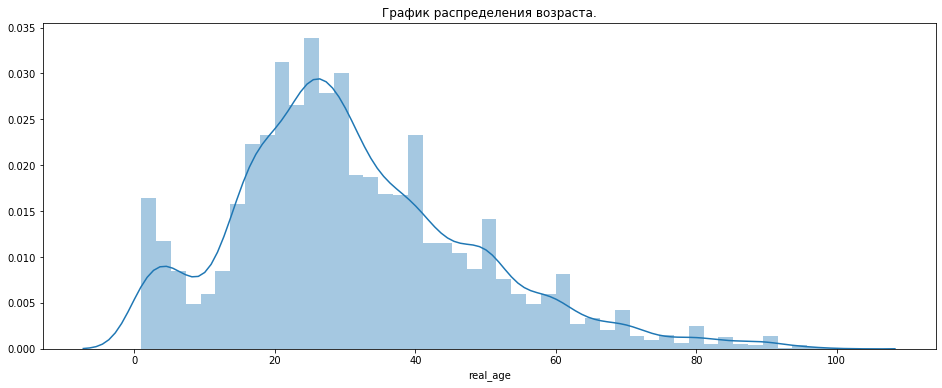

In [5]:
plt.figure(figsize=(16, 6))
# <Построим гисттограмму распределения с помощью билиотеки seaborn>
sns.distplot(df['real_age']).set_title('График распределения возраста.')

In [8]:
df['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [13]:
df['real_age'].median()

29.0

In [12]:
df['real_age'].quantile(.995)

88.05000000000018

Распределение напоминает Пуассоновское, чем больше возраст, тем меньше фотографий ему соответствующих. Пик приходится на возраст около 25-30 лет. Аномальный возраст - 88 лет и более. Чаще всего встречается возраст от 20 лет до 41 года.

Напечатаем на экране 16 фотографий из датасета, над ними будет указан возраст людей:

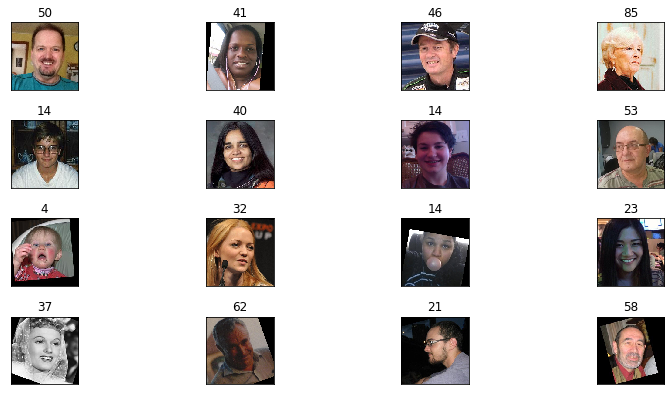

In [6]:
x, y = next(train_gen_flow)

fig = plt.figure(figsize=(11,11))
for i in range(16):
    fig.add_subplot(8, 4, i+1)
    plt.imshow(x[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(y[i])
    plt.tight_layout()

В данном датасете лицо всегда в центре. В некоторых фотографиях имеется черная часть, изображение как бы обрезано. Но создается впечатление что лицо всегда в центре, и потому нейросеть будут выстраивать важные зависимости именно там.

Если аугментировать фото горизонтальным отзеркаливанием, то данные не будут искажены, так как и так в датасете присутствуют данные со смотрящими в разные стороны людьми. Сдвигать лица с центра и отзеркаливать вертикально не стоит, это будет искажение данных, на мой взгляд.

### Вывод

Данные были проанализированы, фото изучены. Количества файлов достаточно для обучения. Размеры фото не слишком велики, а потому есть шансы закончить обучение модели в этом году. Приступим.

# 2. Обучение модели <a class="anchor" id="2"></a>

Тут изображен код модели и ее вывод:

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
 
 
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow
 
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow
 
def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.0004)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
 
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=25,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/25
2020-08-12 14:20:08.871599: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-08-12 14:20:12.861503: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 123s - loss: 193.9691 - mae: 10.4960 - val_loss: 303.6091 - val_mae: 12.9750
Epoch 2/25
356/356 - 45s - loss: 122.3580 - mae: 8.4595 - val_loss: 251.8185 - val_mae: 11.9927
Epoch 3/25
356/356 - 45s - loss: 97.6787 - mae: 7.4897 - val_loss: 135.8702 - val_mae: 8.7421
Epoch 4/25
356/356 - 45s - loss: 81.2591 - mae: 6.8843 - val_loss: 93.2938 - val_mae: 7.2906
Epoch 5/25
356/356 - 45s - loss: 66.5913 - mae: 6.2411 - val_loss: 159.3815 - val_mae: 9.4251
Epoch 6/25
356/356 - 45s - loss: 57.8756 - mae: 5.8418 - val_loss: 95.1881 - val_mae: 7.4994
Epoch 7/25
356/356 - 45s - loss: 47.8242 - mae: 5.2679 - val_loss: 172.7118 - val_mae: 10.6009
Epoch 8/25
356/356 - 45s - loss: 41.0788 - mae: 4.9313 - val_loss: 90.2932 - val_mae: 7.2702
Epoch 9/25
356/356 - 45s - loss: 37.2358 - mae: 4.6659 - val_loss: 129.6164 - val_mae: 8.4494
Epoch 10/25
356/356 - 45s - loss: 32.7791 - mae: 4.3503 - val_loss: 96.6157 - val_mae: 7.3120
Epoch 11/25
356/356 - 45s - loss: 25.6437 - mae: 3.9069 - val_loss: 93.9555 - val_mae: 7.4805
Epoch 12/25
356/356 - 45s - loss: 23.9419 - mae: 3.7726 - val_loss: 97.1068 - val_mae: 7.4163
Epoch 13/25
356/356 - 45s - loss: 20.1362 - mae: 3.4493 - val_loss: 77.6035 - val_mae: 6.6958
Epoch 14/25
356/356 - 45s - loss: 19.2785 - mae: 3.3770 - val_loss: 88.5900 - val_mae: 7.0650
Epoch 15/25
356/356 - 45s - loss: 19.5559 - mae: 3.3978 - val_loss: 89.8029 - val_mae: 7.0054
Epoch 16/25
356/356 - 45s - loss: 19.1582 - mae: 3.3703 - val_loss: 83.3595 - val_mae: 6.9655
Epoch 17/25
356/356 - 45s - loss: 20.3261 - mae: 3.4290 - val_loss: 170.5643 - val_mae: 9.3757
Epoch 18/25
356/356 - 45s - loss: 19.5313 - mae: 3.3855 - val_loss: 178.7199 - val_mae: 9.5235
Epoch 19/25
356/356 - 45s - loss: 19.9346 - mae: 3.4393 - val_loss: 80.9657 - val_mae: 6.6541
Epoch 20/25
356/356 - 45s - loss: 16.0543 - mae: 3.0921 - val_loss: 77.7997 - val_mae: 6.5929
Epoch 21/25
356/356 - 45s - loss: 13.9409 - mae: 2.8538 - val_loss: 89.2035 - val_mae: 7.3023
Epoch 22/25
356/356 - 45s - loss: 12.8756 - mae: 2.7472 - val_loss: 79.6056 - val_mae: 6.7874
Epoch 23/25
356/356 - 45s - loss: 14.4574 - mae: 2.8533 - val_loss: 171.5149 - val_mae: 9.6045
Epoch 24/25
356/356 - 45s - loss: 14.4666 - mae: 2.9021 - val_loss: 74.5301 - val_mae: 6.4693
Epoch 25/25
356/356 - 45s - loss: 12.5347 - mae: 2.7031 - val_loss: 72.5716 - val_mae: 6.3740
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 72.5716 - mae: 6.3740
Test MAE: 6.3740

```

# 3. Анализ обученной модели <a class="anchor" id="3"></a>

Модель ResNet50 создана не нами, а большими профессионалами, поэтому неудивительно что мы получили хороший результат. Также мы использовали предобученные веса, это ускорило обучение. В конце у нас слой пулинга( GlobalAveragePooling2D нужен, чтобы усреднить информацию по всему изображению, то есть получить пиксель с большим количеством каналов) и в выходном слое один нейрон, так как нам в конце нужно получить одно число - возраст. Функция активации ReLU все отрицательные результаты приводит к 0 и нам это отлично подходит. Также была применена аугментация *horizontal_flip*.

Я обучил три модели:
Сначала я подобрал *learning rate=0.0005* и 20 эпох, что дало ошибку около 7.5. Затем *learning rate=0.001* и 10 эпох, что дало ошибку около 11, а значит минимум я пропустил. Затем *learning rate=0.0004* и 25 эпох, что дало ошибку около  6.3740, и это я думаю очень близко к минимуму. Исследователи получали на этом датасете ошибку 5.4. Так что у нас хороший результат.